I have time-series measurements from a transient phenomenon. The model that describes my data is

$y = b$ for $t < t_0$

$y = b + A\exp[-\alpha(t-t_0)]$ for $t\geq t_0$

where where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

I generate posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$ using nested sampling. In the last part of the exercise I compare the results obtained from the model to the results obtained by a gaussian profile defined by

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st

# Exploration of the data

 I read the file containing the measurements. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux.

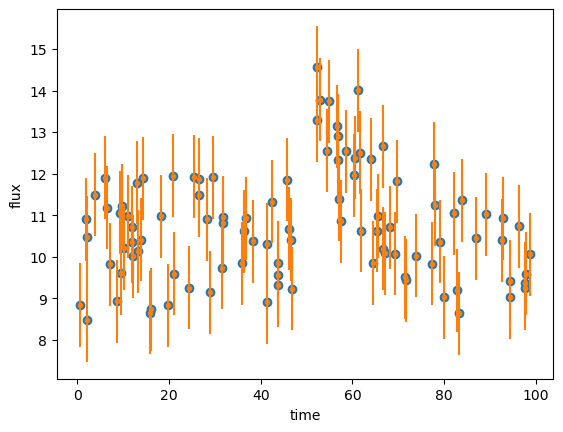

In [2]:
# I read and represent the data
data = np.load("transient.npy")

time = np.zeros(len(data))
flux = np.zeros(len(data))
error_flux = np.zeros(len(data))
for i in range (0, len(data)):
   time[i] = data[i][0]
   flux[i] = data[i][1]
   error_flux[i] = data[i][2]

plt.plot(time, flux, 'o')
plt.errorbar(time, flux, yerr=error_flux, fmt='.')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

# Nested Sampling

I define the following functions:
- the model function
- the log_likelihood function
- the prior function (my priors are: $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, $\ln\alpha\in \mathrm{Uniform}[-5,5]$). 

Note on the prior function: in nested sampling the prior parameters are drawn from a $[0,1]^d$ space, so I need to choose a prior function that defines how to transform a parameter from the normalized space to the original parameter space.

In [3]:
import dynesty

def model(para):
    x = time
    y = np.zeros(len(x))
    for i in range (len(x)):
      if x[i] < para[2]:
        y[i] = para[1]
      elif x[i] >= para[2]:
        y[i] = para[1] + para[3]*np.exp(-(para[0])*(x[i]-para[2]))
    return y

def ln_likelihood (para):
   return -0.5*np.sum((flux - model(para))**2/error_flux**2 + np.log(2*np.pi*error_flux**2))

def prior_uniform(u):
# Transforms samples `u` drawn from the unit cube to those
# from our uniform prior for each variable.
   prior_alp = st.loguniform.ppf(u[0],np.exp(-5),np.exp(5))
   prior_b = 50. * u[1]
   prior_t0 = 100. * u[2]
   prior_A = 50. * u[3]
   prior = [prior_alp, prior_b, prior_t0, prior_A]
   return prior

I run nested sampling

In [4]:
ndim = 4  # number of parameters in the model

sampler = dynesty.NestedSampler(ln_likelihood, prior_uniform, ndim, nlive=300)
sampler.run_nested()
sresults = sampler.results

print("done")

2395it [00:37,  9.63it/s, bound: 73 | nc: 120 | ncall: 43497 | eff(%):  5.506 | loglstar:   -inf < -178.459 <    inf | logz: -185.348 +/-  0.140 | dlogz: 34.728 >  0.309]   c:\Users\marti\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
c:\Users\marti\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or di

done


I plot a summary of the run

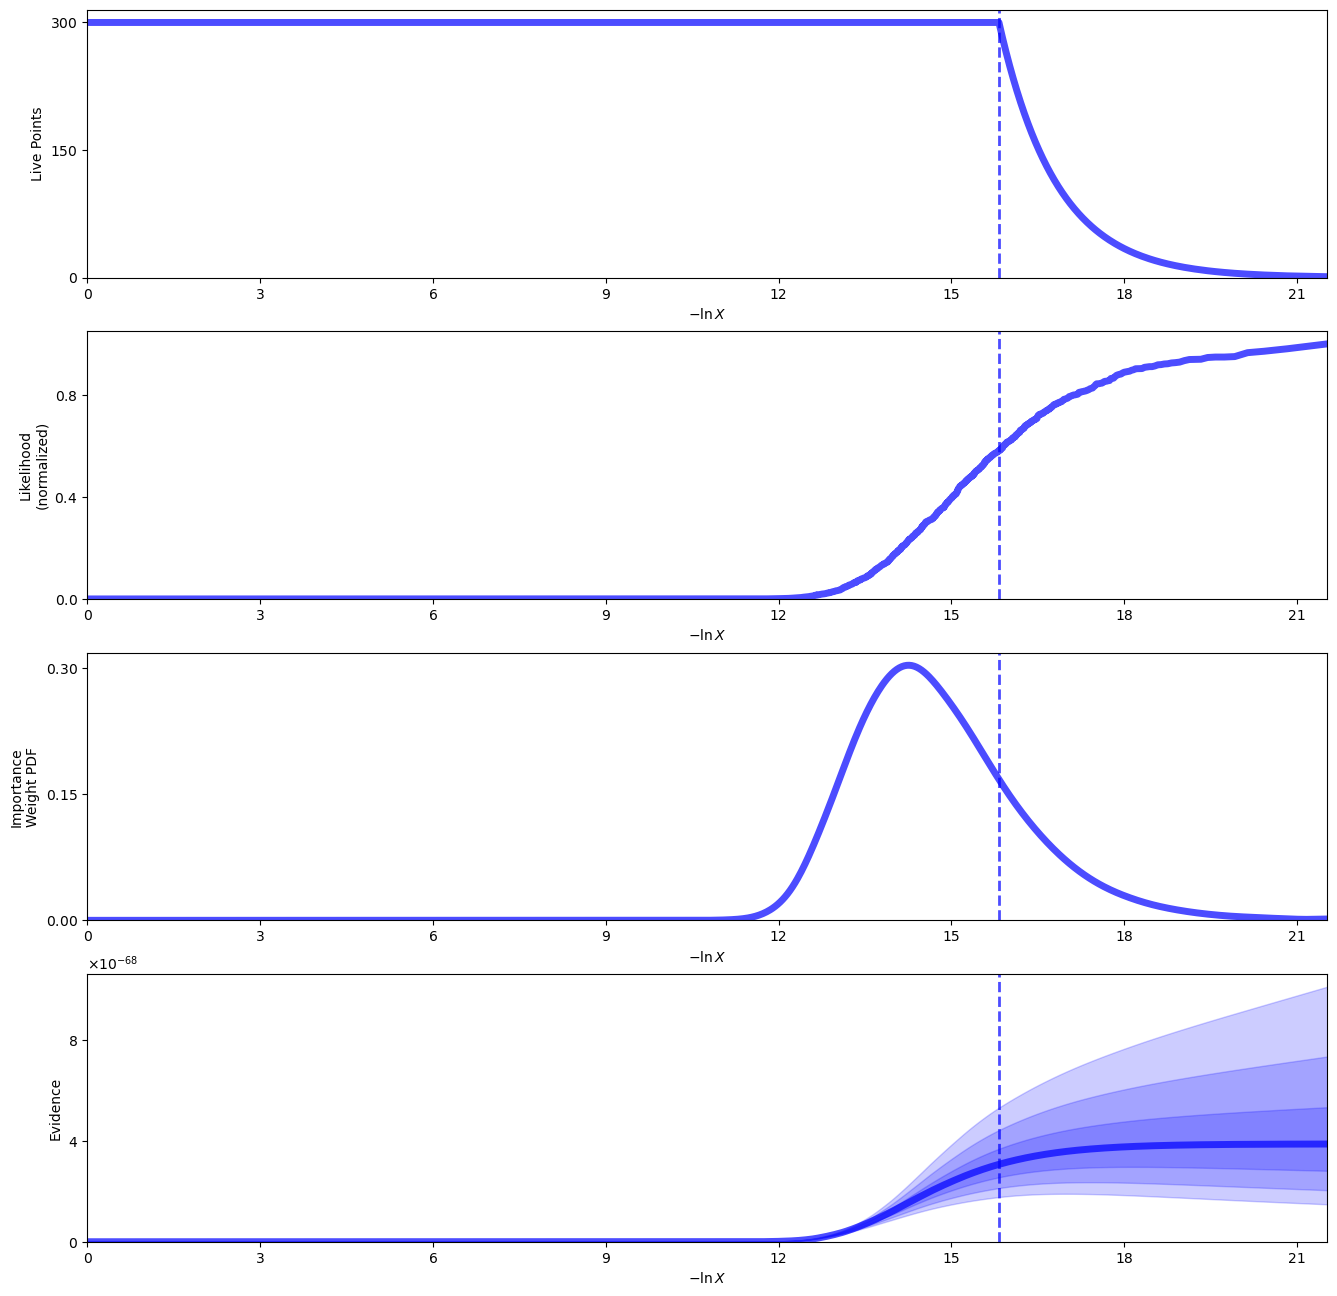

In [5]:
from dynesty import plotting as dyplot

# Plot a summary of the run
rfig, raxes = dyplot.runplot(sresults)

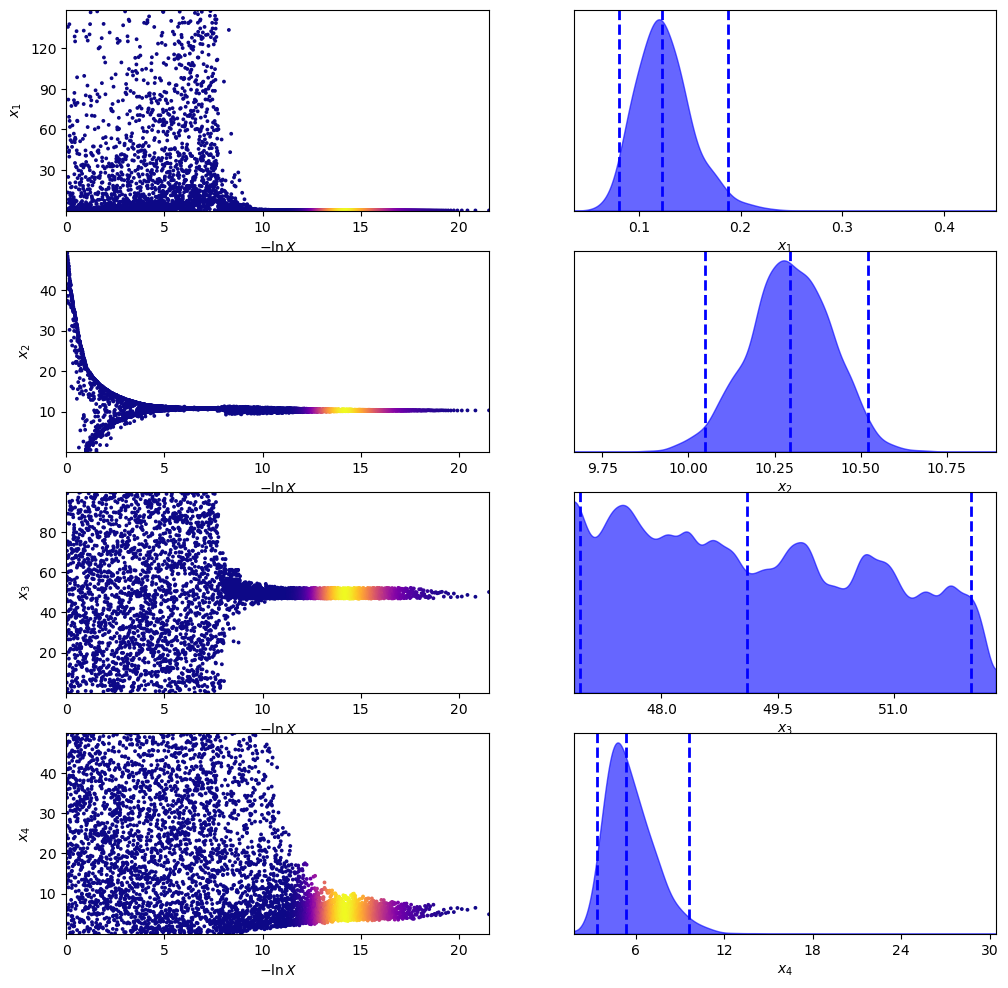

In [6]:
tfig, taxes = dyplot.traceplot(sresults)

Corner plot

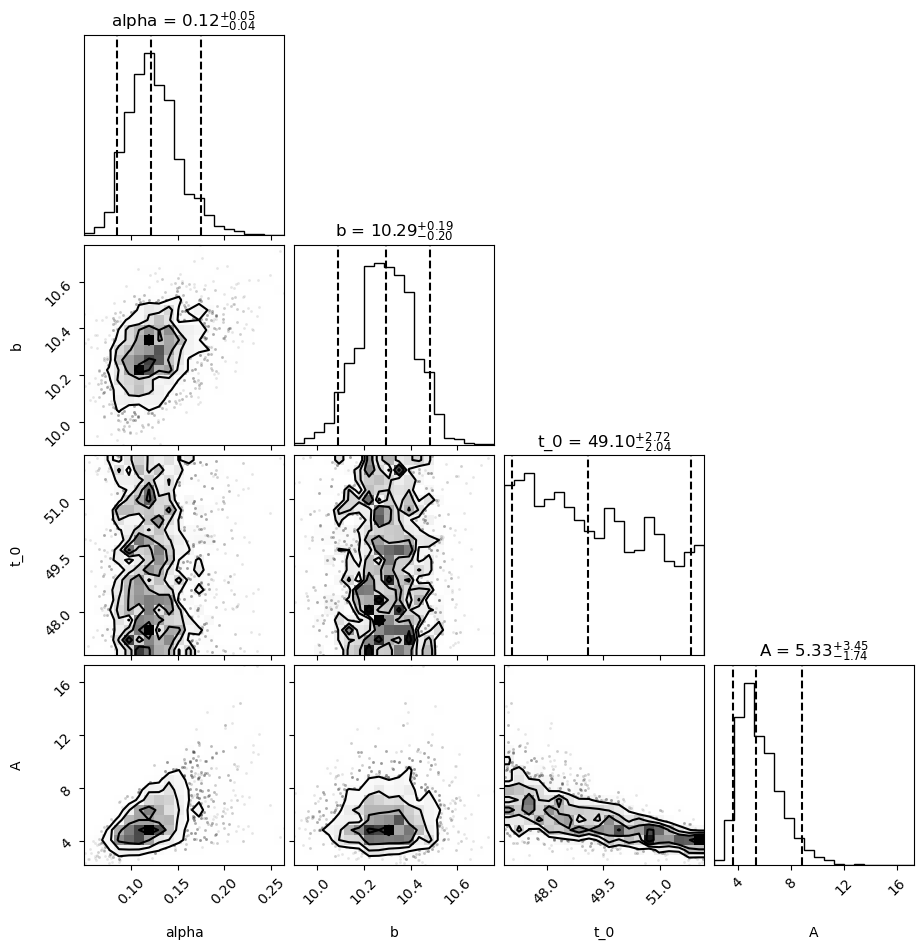

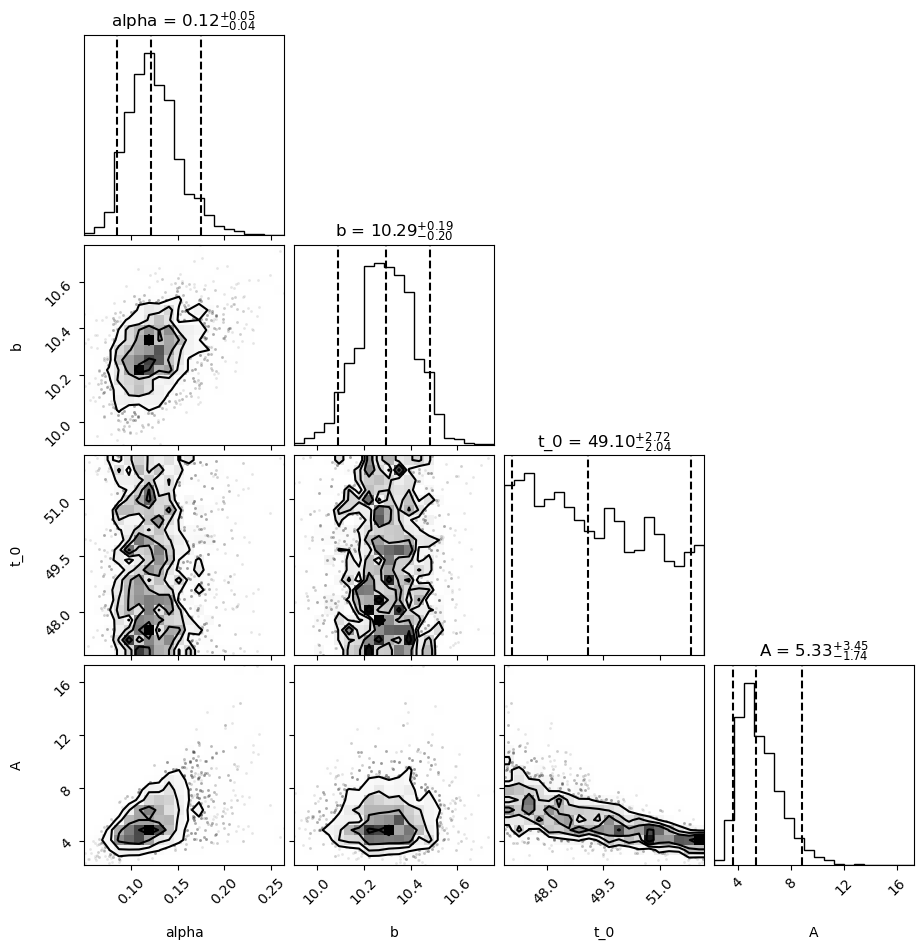

In [9]:
import corner
from dynesty import utils as dyfunc

samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
# logwt = the log_weight (unnormalized) associated with each sample
# logz = the cumulative evidence at each iteration (sample): the final evidence is the last element of logz

labels = ["alpha","b", "t_0", "A"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal, labels=labels, show_titles=True, quantiles=[0.05, 0.5, 0.95])

In [10]:
sresults.summary()

Summary
nlive: 300
niter: 4755
ncall: 87255
eff(%):  5.793
logz: -155.220 +/-  0.320


# Nested Sampling with a Gaussian profile

In [11]:
ndim = 4

#para = [sigma, b, t_0, A]
def model_new(para):
    x = time
    y = np.zeros(len(x))
    for i in range (len(x)):
        y[i] = para[1] + para[3]*np.exp((-(x[i]-para[2])**2) / (2*(para[0])**2))
    return y

def ln_likelihood_new (para):
   return -0.5*np.sum((flux - model_new(para))**2/error_flux**2 + np.log(2*np.pi*error_flux**2))

def prior_uniform_new(u):
# Transforms samples `u` drawn from the unit cube to samples to those
# from our uniform prior for each variable.
   prior_sigma = st.loguniform.ppf(u[0],np.exp(-5),np.exp(5))  # I decide to use the same prior I used for alpha
   prior_b = 50. * u[1]
   prior_t0 = 100. * u[2]
   prior_A = 50. * u[3]
   prior = [prior_sigma, prior_b, prior_t0, prior_A]
   return prior


# Nested sampling
sampler_new = dynesty.NestedSampler(ln_likelihood_new, prior_uniform_new, ndim, nlive=300)
sampler_new.run_nested()
sresults_new = sampler_new.results

print("done")

1484it [00:09, 72.32it/s, bound: 8 | nc: 38 | ncall: 14910 | eff(%):  9.953 | loglstar:   -inf < -191.624 <    inf | logz: -199.438 +/-  0.152 | dlogz: 28.124 >  0.309]     c:\Users\marti\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
1537it [00:10, 63.04it/s, bound: 10 | nc: 23 | ncall: 15947 | eff(%):  9.638 | loglstar:   -inf < -188.695 <    inf | logz: -196.300 +/-  0.151 | dlogz: 24.791 >  0.309]c:\Users\marti\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using

done


I plot a summary of the run

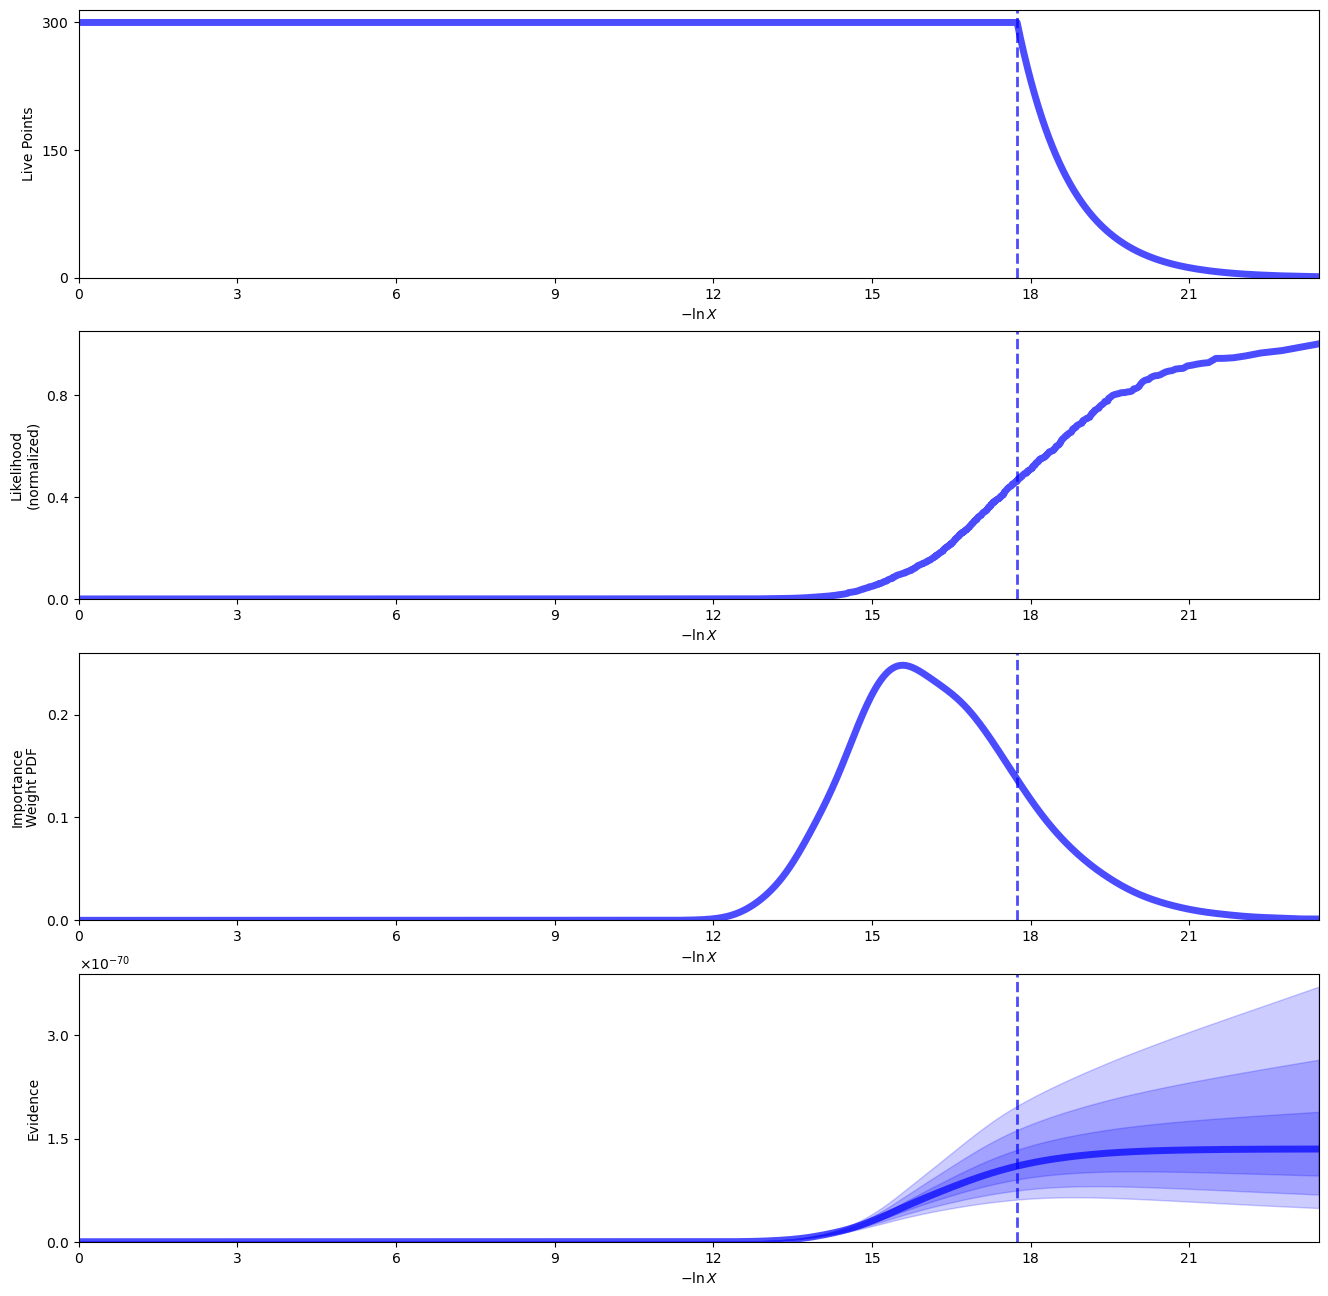

In [12]:
# Plot a summary of the run
rfig, raxes = dyplot.runplot(sresults_new)

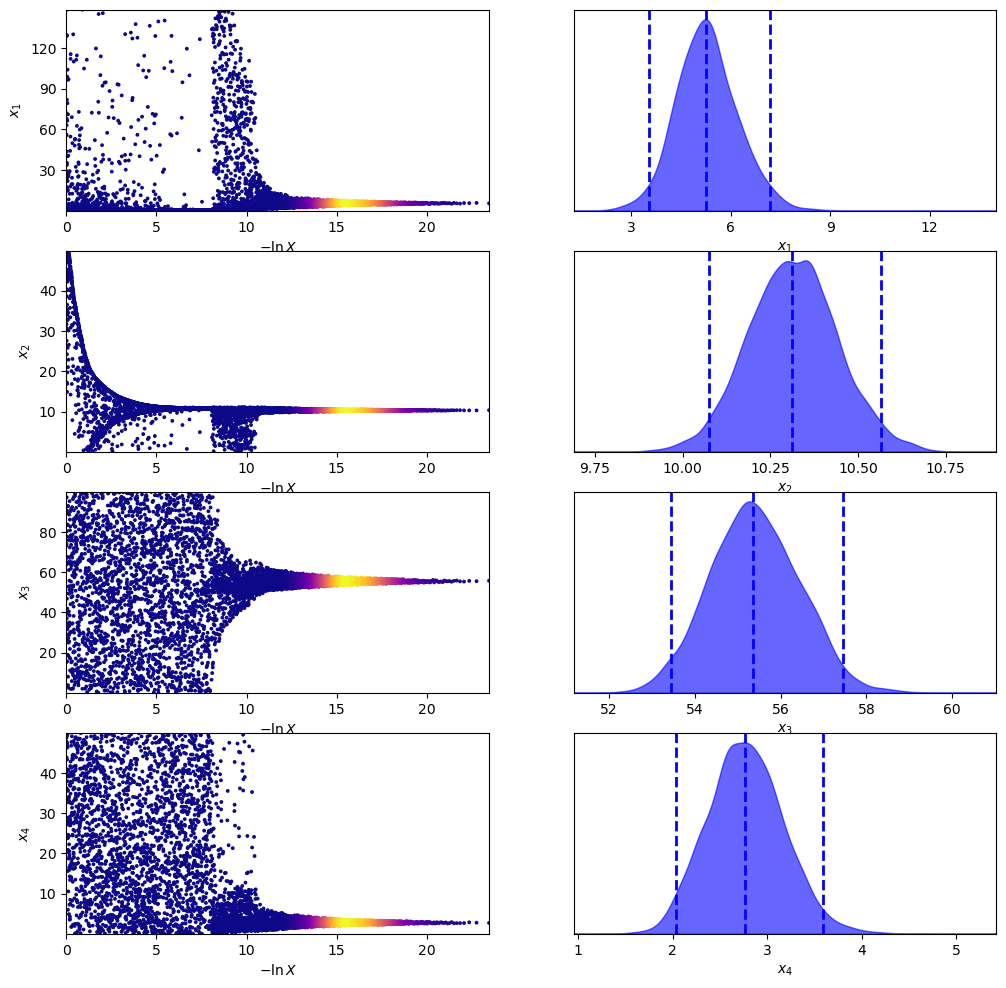

In [13]:
tfig, taxes = dyplot.traceplot(sresults_new)

Corner plot

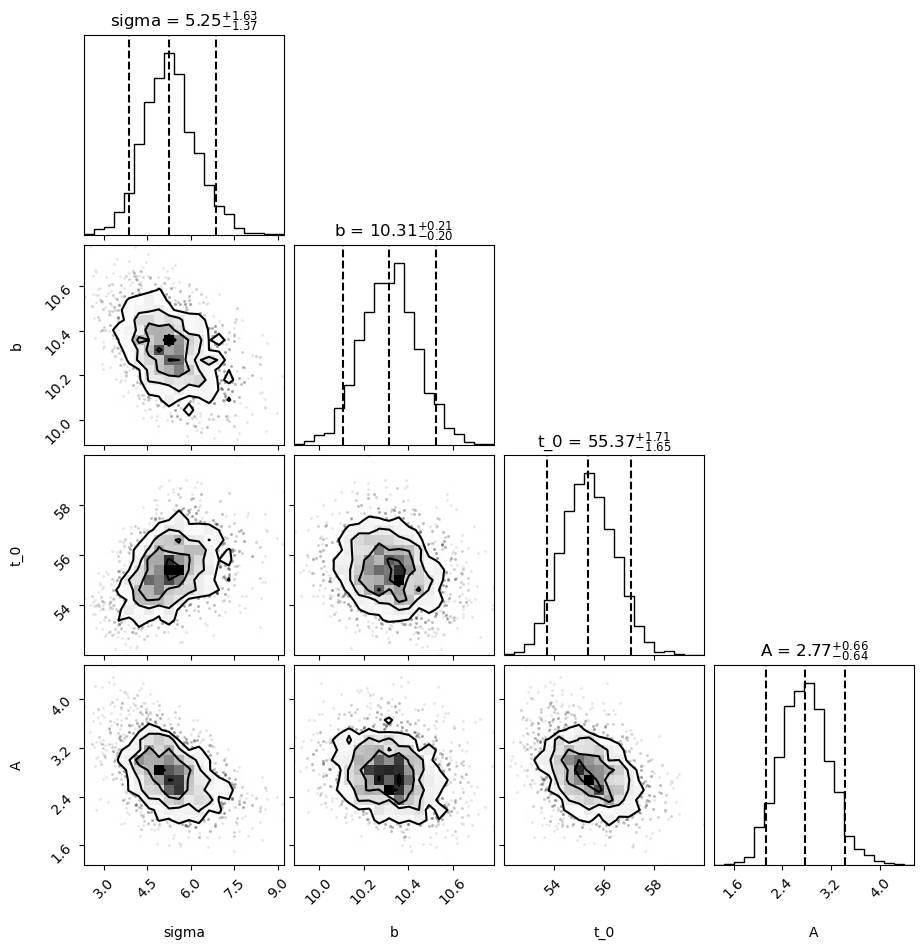

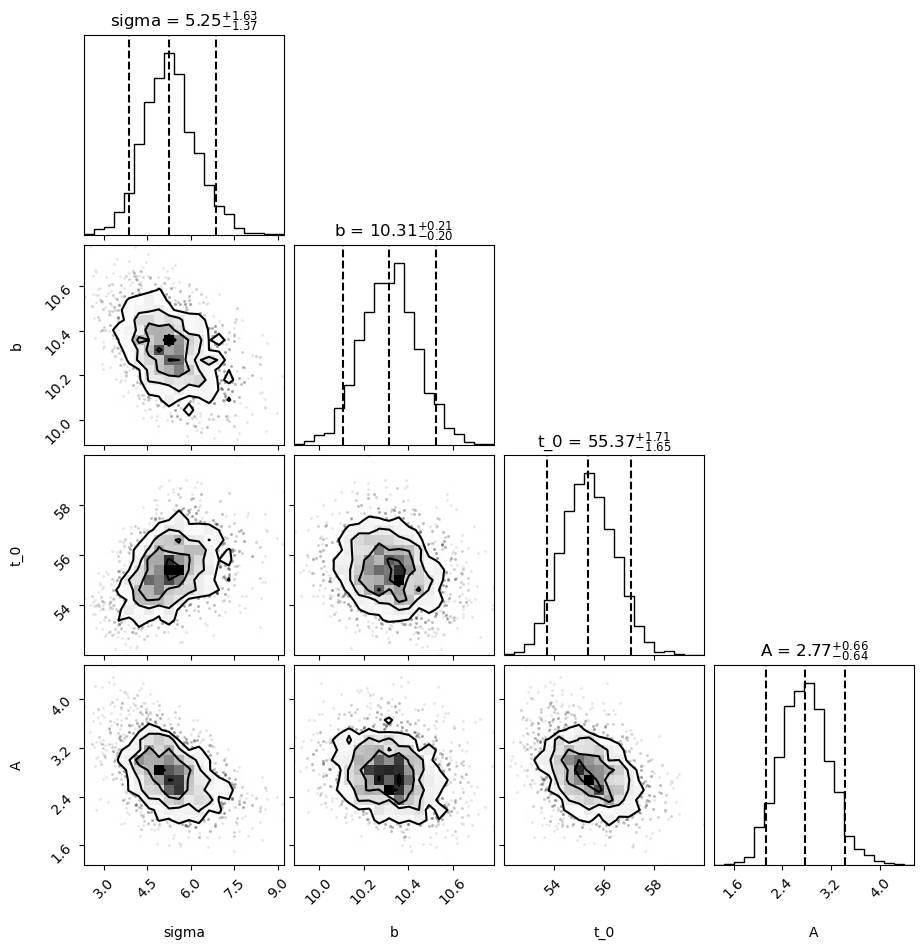

In [14]:
samples = sresults_new.samples  # samples
weights = np.exp(sresults_new.logwt - sresults_new.logz[-1])  # normalized weights
# logwt = the log-weight (unnormalized) associated with each sample
# logz = the cumulative evidence at each iteration (sample)

labels = ['sigma', 'b', 't_0', 'A']

samples_equal_new = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal_new, labels=labels, show_titles=True, quantiles=[0.05, 0.5, 0.95])

In [15]:
sresults_new.summary()

Summary
nlive: 300
niter: 5331
ncall: 279365
eff(%):  2.016
logz: -160.883 +/-  0.337


# Bayesian evidence

I compute the Bayes factor between the two models, which is the ratio between the evidence of the burst model and the evidence of the gaussian model.

In [16]:
# Burst model
# Extract sampling results
sample = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence = sresults.logz[-1] #evidence
print("Burst model, Bayesian evidence", np.exp(evidence))

# Gaussian
# Extract sampling results
samples_new = sresults_new.samples  # samples
weights_new = np.exp(sresults_new.logwt - sresults_new.logz[-1])  # normalized weights

evidence_new = sresults_new.logz[-1] #evidence
print("Gaussian, Bayesian evidence", np.exp(evidence_new))

Burst model, Bayesian evidence 3.8785116634772184e-68
Gaussian, Bayesian evidence 1.3476331160848591e-70


In [17]:
bayes_factor = np.exp(evidence) / np.exp(evidence_new)
print('The Bayes factor between the two models is B = %.2f' %bayes_factor)

The Bayes factor between the two models is B = 287.80


Since the Bayes factor is > 100, I can conclude that there is “decisive” evidence in favor of the burst model.

# Model curves and data

Text(0, 0.5, 'flux')

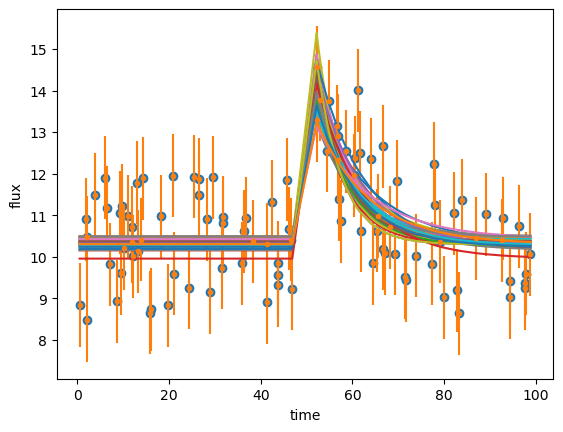

In [18]:
# I plot some models on the data, choosing some random samples of the parameters

# Burst model
tgrid=np.linspace(0,100,100)

chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=30)]

plt.plot(time, flux, 'o')
plt.errorbar(time, flux, yerr=error_flux, fmt='.')

y_models = []
for i in chosen_samples:
    y_models.append(model(i))
    plt.plot(time, model(i))
    
plt.xlabel("time")
plt.ylabel("flux")

Text(0, 0.5, 'flux')

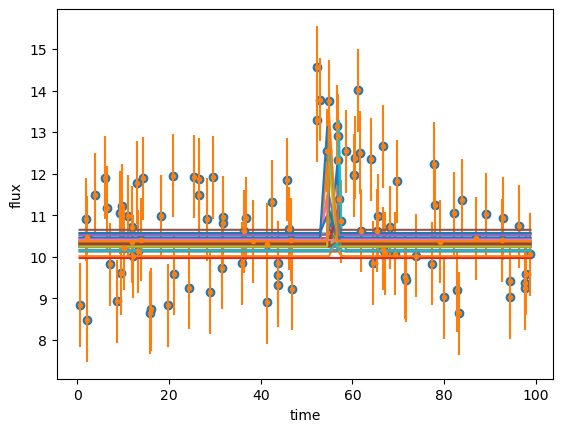

In [19]:
# Gaussian
tgrid=np.linspace(0,100,100)

chosen_samples= samples_equal_new[np.random.choice(len(samples_equal_new),size=30)]

plt.plot(time, flux, 'o')
plt.errorbar(time, flux, yerr=error_flux, fmt='.')

y_models = []
for i in chosen_samples:
    y_models.append(model(i))
    plt.plot(time, model(i))
    
plt.xlabel("time")
plt.ylabel("flux")